<a href="https://colab.research.google.com/github/cdixson-ds/DS-Unit-2-Applied-Modeling/blob/master/LS_DS_231_assignment_sent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [X] Choose your target. Which column in your tabular dataset will you predict?
- [X] Is your problem regression or classification?
- [X] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [X] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

# Choose your target: 

I am trying to predict the 'label' column which determines if the review is
positive or negative

Classification: This is a classification problem because I am attempting to predict a discrete label

Evaluation Metrics: I'm going to 

In [0]:
import pandas as pd

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [0]:
train = pd.read_csv('Train.csv')

In [107]:
#target = label

train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [0]:
test = pd.read_csv('Test.csv')

In [0]:
valid = pd.read_csv('Valid.csv')

In [110]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 7, 4

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Find Distribution: because the distribution is balanced I will use accuracy as an evaluation metric

In [111]:
#Distribution is balanced

train['label'].value_counts(True)

0    0.500475
1    0.499525
Name: label, dtype: float64

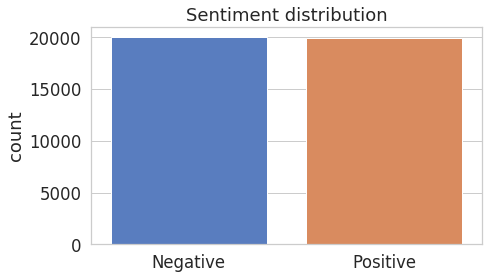

In [113]:
#Distribution bar plot

f = sns.countplot(x = 'label', data=train)
f.set_title("Sentiment distribution")
f.set_xticklabels(['Negative', 'Positive'])
plt.xlabel("")
plt.show()

In [114]:
train.groupby('label').describe()

text                                                               
       count unique                                                top freq
label                                                                      
0      20019  19815  When i got this movie free from my job, along ...    3
1      19981  19908  Hilarious, clean, light-hearted, and quote-wor...    4

In [115]:
#Create a length column

train['length'] = train['text'].apply(len)
train.head()

,text,label,length
0,I grew up (b. 1965) watching and loving the Th...,0,874
1,"When I put this movie in my DVD player, and sa...",0,1811
2,Why do people who do not know what a particula...,0,983
3,Even though I have great interest in Biblical ...,0,351
4,Im a die hard Dads Army fan and nothing will e...,1,983


In [116]:
train.length.describe()

count    40000.000000
mean      1310.293250
std        988.358599
min         32.000000
25%        698.000000
50%        973.000000
75%       1596.000000
max      13704.000000
Name: length, dtype: float64

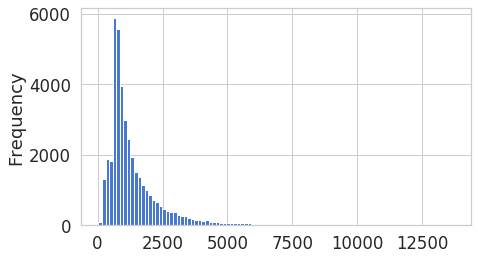

In [41]:
#Length histogram

train['length'].plot.hist(bins = 100)
plt.show()

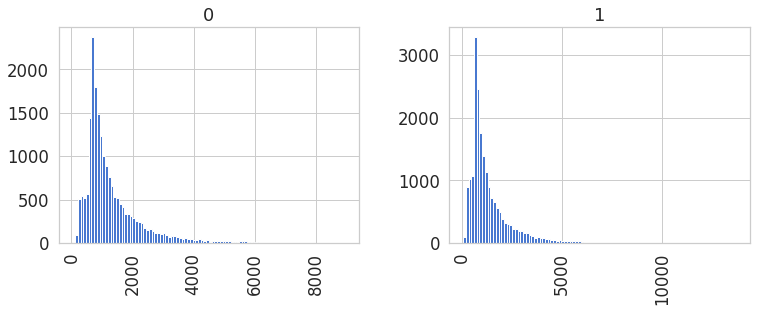

In [48]:
#positive reviews are longer

train.hist(column='length', by='label', bins=100, figsize=(12,4))
plt.show()

Cleaning Data

In [0]:
from bs4 import BeautifulSoup

def clean_text(X):
  #remove HTML tags
  X = BeautifulSoup(X).get_text()

  #remove all non letters from text
  letters_only = re.sub("[^a-zA-Z]", " ", X) 

  #lower case, split words
  words = letters_only.lower().split()

  #stopwords variable
  stops = set(stopwords.words('english'))

  #Remove stop words and return
  return [w for w in words if not w in stops]

In [64]:
#clean text, add word count coloumn

train['clean_review'] = train['text'].apply(clean_text)
train['length_clean_review'] = train['clean_review'].apply(len)
train.head()

,text,label,length,clean_review,length_clean_review
0,I grew up (b. 1965) watching and loving the Th...,0,874,"[grew, b, watching, loving, thunderbirds, mate...",85
1,"When I put this movie in my DVD player, and sa...",0,1811,"[put, movie, dvd, player, sat, coke, chips, ex...",159
2,Why do people who do not know what a particula...,0,983,"[people, know, particular, time, past, like, f...",95
3,Even though I have great interest in Biblical ...,0,351,"[even, though, great, interest, biblical, movi...",33
4,Im a die hard Dads Army fan and nothing will e...,1,983,"[im, die, hard, dads, army, fan, nothing, ever...",100


In [65]:
train.describe()

,label,length,length_clean_review
count,40000.000000,40000.000000,40000.00000
mean,0.499525,1310.293250,118.22610
std,0.500006,988.358599,89.33317
min,0.000000,32.000000,3.00000
25%,0.000000,698.000000,63.00000
50%,0.000000,973.000000,88.00000
75%,1.000000,1596.000000,144.00000
max,1.000000,13704.000000,1416.00000


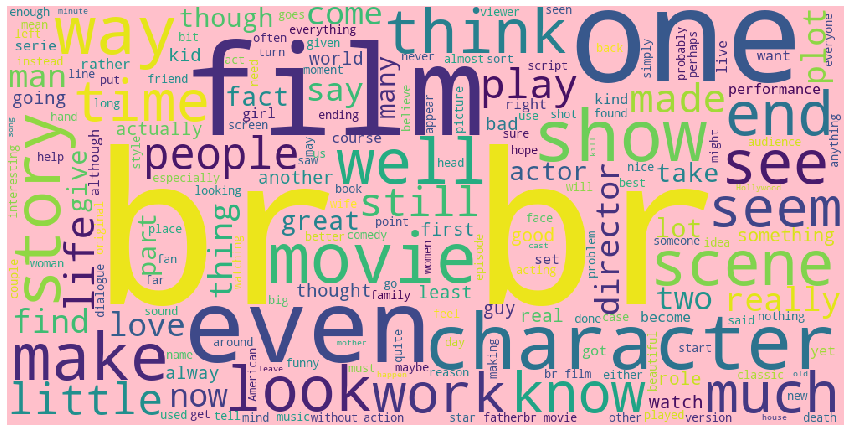

In [68]:
### Word CLoud
#Plot wordcloud
#need to remove stop words and 'br' tag
word_cloud = WordCloud(width = 1000, height = 500, background_color = 'pink').generate(
                        ''.join(train['text']))

plt.figure(figsize = (15,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

#word_cloud.to_file('aa.png')   #for saving file

In [0]:
#Vectorization

from sklearn.feature_extraction.text import CountVectorizer

bow_transform = CountVectorizer(analyzer=clean_text).fit(train['text'])

In [72]:
#print total number of words
print(len(bow_transform.vocabulary_))

92130


In [73]:
#Look at one review

review1 = train['text'][1]
print(review1)

When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, b

In [75]:
#Review one in vector form

bow1 = bow_transform.transform([review1])
print(bow1)
print(bow1.shape)

  (0, 713)	1
  (0, 1055)	1
  (0, 2133)	1
  (0, 2183)	1
  (0, 2232)	1
  (0, 2953)	2
  (0, 3517)	1
  (0, 4412)	1
  (0, 4687)	2
  (0, 4871)	1
  (0, 5271)	1
  (0, 5557)	2
  (0, 7614)	1
  (0, 9921)	1
  (0, 12099)	1
  (0, 12364)	1
  (0, 12416)	1
  (0, 12488)	2
  (0, 13255)	1
  (0, 13339)	1
  (0, 13980)	1
  (0, 15413)	1
  (0, 15686)	1
  (0, 16769)	1
  (0, 17531)	1
  :	:
  (0, 71807)	2
  (0, 72161)	1
  (0, 72240)	1
  (0, 73168)	1
  (0, 73704)	1
  (0, 73844)	1
  (0, 73964)	2
  (0, 75074)	1
  (0, 75820)	1
  (0, 76983)	1
  (0, 77534)	1
  (0, 77773)	2
  (0, 77787)	1
  (0, 78116)	1
  (0, 79339)	1
  (0, 79561)	1
  (0, 81843)	2
  (0, 82167)	2
  (0, 84395)	1
  (0, 84451)	1
  (0, 87620)	1
  (0, 88099)	3
  (0, 88980)	1
  (0, 89422)	1
  (0, 90706)	1
(1, 92130)


In [85]:
print(bow_transform.get_feature_names()[2953])  #word at specific index, animation occurs twice
print(bow_transform.get_feature_names()[89422])  #whatever occurs once

animation
whatever


In [0]:
#create bow from reviews

review_bow = bow_transform.transform(train['text'])

In [79]:
#Check the shape and non zero occurances

print('Shape of sparse matrix: ', review_bow.shape)
print('Amount of non-zero occurences: ', review_bow.nnz)

Shape of sparse matrix:  (40000, 92130)
Amount of non-zero occurences:  3880429


In [81]:
#Check sparsity of sparse matrix

sparsity = 100 * review_bow.nnz / (review_bow.shape[0] * review_bow.shape[1])
print('sparsity: {}'.format(sparsity))

sparsity: 0.10529765005969825


In [84]:
#Term frequency: how frequently a term is used / length
#IDF: Inverse Document Frequency, measures importance of the term
#rare words have more importance, are scaled up using:
#  IDF(t) = log_e(Total # of reviews/ # of reviews with term t in it)

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(review_bow)
tfidf1 = tfidf_transformer.transform(bow1)
print(tfidf1)

  (0, 90706)	0.026137301051488517
  (0, 89422)	0.056923276328943305
  (0, 88980)	0.057480361725566094
  (0, 88099)	0.1597350180951733
  (0, 87620)	0.13406152683829606
  (0, 84451)	0.0645842896543438
  (0, 84395)	0.042450140087212186
  (0, 82167)	0.05056716874303545
  (0, 81843)	0.0885177439420542
  (0, 79561)	0.06041028834015121
  (0, 79339)	0.06746916167602943
  (0, 78116)	0.05295629189890247
  (0, 77787)	0.05579468190442574
  (0, 77773)	0.05444045766379554
  (0, 77534)	0.03388315717963789
  (0, 76983)	0.05608349207974265
  (0, 75820)	0.05553318203338499
  (0, 75074)	0.13406152683829606
  (0, 73964)	0.10853144525334646
  (0, 73844)	0.05503623376383264
  (0, 73704)	0.06662451993066369
  (0, 73168)	0.06511414947128775
  (0, 72240)	0.043776165746460385
  (0, 72161)	0.05749249321196453
  (0, 71807)	0.06230971751648068
  :	:
  (0, 17531)	0.03009465401116322
  (0, 16769)	0.07450098485785372
  (0, 15686)	0.04138686128425434
  (0, 15413)	0.08855305499837268
  (0, 13980)	0.09605635475870793
  

In [86]:
#check what the IDF of the word 'animation' and 'whatever' is

print(tfidf_transformer.idf_[bow_transform.vocabulary_['animation']])
print(tfidf_transformer.idf_[bow_transform.vocabulary_['whatever']])

4.937365813099941
4.629692594169596


In [87]:
#transform the whole bag of words

review_tfidf = tfidf_transformer.transform(review_bow)
print(review_tfidf.shape)

(40000, 92130)


In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train['text'], train['label'], test_size=0.22, random_state=42)

len(X_train), len(X_test), len(X_train) + len(X_test)

(31200, 8800, 40000)

In [97]:
#Logistic Regression Model

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(random_state=101)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_train)
pred(predictions,y_train)

CONFUSION MATRIX ------->> 
col_0      0      1
label              
0      14519   1123
1        837  14721



In [98]:
#Test Set Result
predictions = pipeline.predict(X_test)
pred(predictions,y_test)

CONFUSION MATRIX ------->> 
col_0     0     1
label            
0      3868   509
1       415  4008



In [104]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4283
           1       0.91      0.89      0.90      4517

    accuracy                           0.90      8800
   macro avg       0.89      0.90      0.89      8800
weighted avg       0.90      0.90      0.90      8800



In [102]:
from sklearn.metrics import accuracy_score

accuracy_score(predictions, y_test)

0.895

In [120]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier(n_estimators = 500)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_train)
pred(predictions,y_train)

CONFUSION MATRIX ------->> 
col_0      0      1
label              
0      15642      0
1          0  15558



In [121]:
#Test Set Result
predictions = pipeline.predict(X_test)
pred(predictions,y_test)

CONFUSION MATRIX ------->> 
col_0     0     1
label            
0      3795   582
1       589  3834



In [122]:
accuracy_score(predictions, y_test)

0.8669318181818182